In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


class Game:
    def __init__(self, player_x, player_o):
        self.player_x = player_x
        self.player_o = player_o
        self.state = (0,)*9
        self.available = list(range(9))
        self.state_sequence = [self.state]
        self.move_sequence = []
        self.init_graphics()
    
    def init_graphics(self):
        m = 10

        cross = np.zeros([5*m,5*m],dtype=np.float32)
        cross = cv2.line(cross, (1*m,1*m), (4*m,4*m), 1, (4*m)//5, cv2.LINE_AA)
        cross = cv2.line(cross, (4*m,1*m), (1*m,4*m), 1, (4*m)//5, cv2.LINE_AA)

        circle = np.zeros([5*m,5*m],dtype=np.float32)
        circle = cv2.circle(circle, ((5*m)//2,(5*m)//2), (3*m)//2, 1, (4*m)//5)

        board = np.zeros([17*m,17*m])
        board = cv2.line(board, ((11*m)//2, m//5), ((11*m)//2, 17*m-m//5), 
                                                      1, (4*m//5), cv2.LINE_AA)
        board = cv2.line(board, (m//5, (11*m)//2), (17*m-m//5, (11*m)//2), 
                                                      1, (4*m//5), cv2.LINE_AA)
        board = cv2.line(board, ((23*m)//2, m//5), ((23*m)//2, 17*m-m//5), 
                                                      1, (4*m//5), cv2.LINE_AA)
        board = cv2.line(board, (m//5, (23*m)//2), (17*m-m//5, (23*m)//2), 
                                                      1, (4*m//5), cv2.LINE_AA)

        self.cross = cross
        self.circle = circle
        self.board = board
        self.board_posistions = [[  0,  0], [  0, 60], [  0,120], 
                                 [ 60,  0], [ 60, 60], [ 60,120], 
                                 [120,  0], [120, 60], [120,120]]
    
    def render_state(self, state=None):
        if state is None:
            state = self.state
        
        board = self.board.copy()
        for k in range(9):
            if state[k]==0:
                continue
            elif state[k]>0:
                img = self.cross
            elif state[k]<0:
                img = self.circle

            start_x,start_y = self.board_posistions[k]
            end_x,end_y=start_x+img.shape[0], start_y+img.shape[1]
            board[start_x:end_x,start_y:end_y]=img
        
        return board
    
    def check_win(self):
        for i in range(3):
            if self.state[i]==self.state[i+3]==self.state[i+6]:
                return self.state[i]
            
            ss = i*3
            if self.state[ss]==self.state[ss+1]==self.state[ss+2]:
                return self.state[ss]

        if self.state[0]==self.state[4]==self.state[8]:
            return self.state[0]
        if self.state[2]==self.state[4]==self.state[6]:
            return self.state[2]
        return 0
    
    def play(self):
        while True:
            move = self.player_x(self)
            self.move_sequence.append(move)
            self.state = tuple((1 if i==move else self.state[i]) for i in range(9))
            self.available.remove(move)
            self.state_sequence.append(self.state)
            win_val = self.check_win()
            yield win_val
            if win_val:
                self.result = win_val
                return
            
            if not len(self.available):
                self.result = 0
                return
            
            move = self.player_o(self)
            self.move_sequence.append(move)
            self.state = tuple((-1 if i==move else self.state[i]) for i in range(9))
            self.available.remove(move)
            self.state_sequence.append(self.state)
            win_val = self.check_win()
            yield win_val
            if win_val:
                self.result = win_val
                return

In [2]:
import matplotlib.pyplot as plt

def human_player(game):
    move = int(input("Your move: "))
    return move

def view_game(game):
    plt.imshow(game.render_state(),cmap='gray')
    plt.axis('off')
    plt.show()
    plt.pause(0.1)

def player_vs_player(player_x, player_o, view=True):
    game = Game(player_x, player_o)
    if view: view_game(game)
    for win_val in game.play():
        if view:
            view_game(game)
            if win_val > 0:
                print("Player 1 wins!")
            elif win_val < 0:
                print("Player 2 wins!")
    return game

In [ ]:
game=player_vs_player(human_player, human_player)

In [11]:
game.state_sequence

[(0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1, 0, 0, 0, 0),
 (-1, 0, 0, 0, 1, 0, 0, 0, 0),
 (-1, 0, 0, 1, 1, 0, 0, 0, 0),
 (-1, -1, 0, 1, 1, 0, 0, 0, 0),
 (-1, -1, 0, 1, 1, 1, 0, 0, 0)]

In [12]:
game.move_sequence

[4, 0, 3, 1, 5]

In [3]:
from collections import defaultdict
import random

class Q_Player:
    def __init__(self, epsilon=0.1, gamma=0.9, alpha=0.1):
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        
        self.Q = defaultdict(lambda: defaultdict(float))
    
    def __call__(self, game):
        if random.uniform(0,1)<self.epsilon:
            move = random.choice(game.available)
        else:
            available = game.available
            random.shuffle(available)
            move = max(available, key=lambda x: self.Q[game.state][x])
        return move
    
    def backup_update(self, game):
        if game.result==0:
            return
        elif game.result>0:
            reward = game.result
        else:
            reward = -game.result
        
        state = game.state_sequence[-2]
        move = game.move_sequence[-1]
        self.Q[state][move] += self.alpha*(reward - self.Q[state][move])
        
        for t in reversed(range(len(game.move_sequence)-1)):
            state = game.state_sequence[t]
            move = game.move_sequence[t]
            next_state = game.state_sequence[t+1]
            
            self.Q[state][move] -= self.alpha*(self.gamma*max(self.Q[next_state].values()) + self.Q[state][move])
        
        

In [4]:
q_player = Q_Player(epsilon=0.1, gamma=0.9, alpha=0.1)

In [20]:
q_player.backup_update(game)
q_player.Q

defaultdict(<function __main__.Q_Player.__init__.<locals>.<lambda>()>,
            {(-1, -1, 0, 1, 1, 0, 0, 0, 0): defaultdict(float, {5: 0.1}),
             (-1, 0, 0, 1, 1, 0, 0, 0, 0): defaultdict(float,
                         {1: -0.009000000000000001}),
             (-1, 0, 0, 0, 1, 0, 0, 0, 0): defaultdict(float,
                         {3: 0.0008100000000000002}),
             (0, 0, 0, 0, 1, 0, 0, 0, 0): defaultdict(float,
                         {0: -7.290000000000002e-05,
                          3: -7.290000000000002e-05}),
             (0, 0, 0, 0, 0, 0, 0, 0, 0): defaultdict(float,
                         {4: 1.2465900000000004e-05}),
             (0, -1, 1, -1, 1, 0, 0, 0, 0): defaultdict(float, {6: 0.1}),
             (0, 0, 1, -1, 1, 0, 0, 0, 0): defaultdict(float,
                         {1: -0.009000000000000001}),
             (0, 0, 0, -1, 1, 0, 0, 0, 0): defaultdict(float,
                         {2: 0.0008100000000000002})})

In [5]:
from tqdm import trange

num_games = 200000
q_player.epsilon = 0.9
for _ in trange(num_games):
    game = player_vs_player(q_player, q_player, view=False)
    q_player.backup_update(game)
q_player.epsilon = 0.1

100%|██████████| 200000/200000 [00:25<00:00, 7903.89it/s]


In [7]:
q_player.epsilon = 0

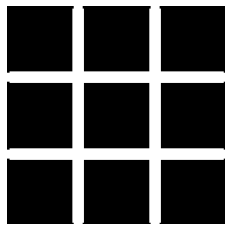

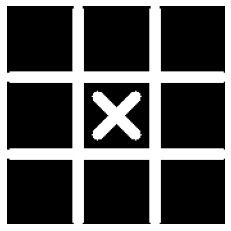

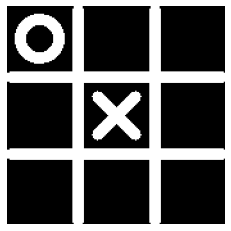

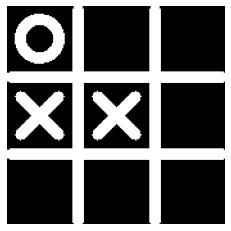

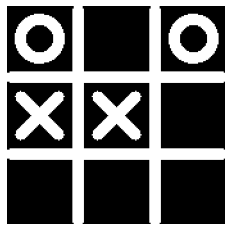

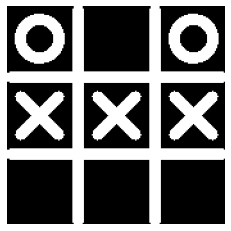

Player 1 wins!


In [8]:
game=player_vs_player(q_player, human_player)
q_player.backup_update(game)

In [9]:
q_player.Q[game.state_sequence[-2]]

defaultdict(float,
            {7: -0.8862416473816019,
             6: -0.8508341173371421,
             1: 0.5082662359336391,
             5: 0.9994924712139436,
             8: -0.87363673933368})

In [27]:
q_player.backup_update(game)

In [13]:
q_player.Q

defaultdict(<function __main__.Q_Player.__init__.<locals>.<lambda>()>,
            {(0, 0, 0, 0, 0, 0, 0, 0, 0): defaultdict(float,
                         {2: 0.0,
                          7: 0.0,
                          3: 0.0,
                          1: 0.0,
                          5: 0.0,
                          6: 0.0,
                          8: 0.0,
                          4: 0.0,
                          0: 0.0}),
             (0, 0, 1, 0, 0, 0, 0, 0, 0): defaultdict(float,
                         {3: 0.0,
                          8: 0.0,
                          5: 0.0,
                          0: 0.0,
                          6: 0.0,
                          4: 0.0,
                          1: 0.0,
                          7: 0.0}),
             (0, 0, 1, -1, 0, 0, 0, 0, 0): defaultdict(float,
                         {5: 0.0,
                          8: 0.0,
                          4: 0.0,
                          0: 0.0,
                          1